In [11]:
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.metrics import mutual_info_score 
from Scripts.util import findAllIterationsInString
from IPython.display import clear_output

##### Load Data

In [2]:
with open('Data/count_ccs.json', 'r') as fp:
    count_ccs = json.load(fp)
 
    # Print the type of data variable
    print("Type:", type(count_ccs))

with open('Data/count_ccs_root.json', 'r') as fp:
    count_ccs_root = json.load(fp)

with open('Data/count_ccs_kw.json', 'r') as fp:
    count_ccs_kw = json.load(fp)

with open('Data/articles_dict.json', 'r') as fp:
    articles_dict = json.load(fp)

Type: <class 'dict'>


In [2]:
articles_df = pd.read_csv("Data/data_processed.csv")

##### Descr of the Created DataFrame

In [3]:
articles_df.tail()

,doi,abstract,ft_body,ccs,keywords,abstract_processed,ft_body_processed,kw_processed,main_concept_root,main_concept_leaf,high_Importance_concept_roots_and_leafs
107908,10.1145/2767134,<p>Online social media allow users to interact...,\n Detection of Political Manipulation in Onli...,{'CCS->Information systems->World Wide Web->We...,"['online social media', 'machine learning', 'o...",online social medium allow user interact one a...,detection political manipulation online commun...,"['online social medium', 'machine learning', '...",information system,web application,"[('information system', 'web application'), ('..."
107909,10.1145/2767135,<p>A classifier that determines if a webpage i...,\n Improving Researcher Homepage Classi.cation...,{'CCS->Information systems->Information retrie...,"['researcher homepage classification', 'co-tra...",classifier determines webpage relevant specifi...,improving researcher homepage classi cation un...,"['researcher homepage classification', 'co-tra...",information system,information retrieval,"[('information system', 'information retrieval')]"
107910,10.1145/2789211,<p>There has been a recent swell of interest i...,\n Diversionary Comments under Blog Posts JING...,{'Mathematics of computing~Bayesian networks':...,"['diversionary comments', 'classification', 'c...",recent swell interest analysis blog comment ho...,diversionary comment blog post jing wang cleme...,"['diversionary comment', 'classification', 'co...",mathematics computing,bayesian network,"[('mathematics computing', 'bayesian network')..."
107911,10.1145/2790304,<p>This work addresses the problem of estimati...,\n Estimating Clustering Coef.cients and Size ...,{'CCS->Theory of computation->Design and analy...,"['estimation', 'clustering coefficient', 'samp...",work address problem estimating social network...,estimating clustering coef cients size social ...,"['estimation', 'clustering coefficient', 'samp...",theory computation,design analysis algorithm,"[('theory computation', 'design analysis algor..."
107912,10.1145/2812812,<p>The Web 2.0 brought new requirements to the...,\n Fona: Quantitative Metric to Measure Focus ...,{'CCS->Hardware': 500},"['aria', 'focus navigation', 'web accessibility']",web 2 0 brought new requirement architecture w...,fona quantitative metric measure focus navigat...,"['aria', 'focus navigation', 'web accessibility']",NaN,NaN,"[(nan, nan)]"


## Keyword Frequency and Ordering

##### Aggregate the dataset by main concept leafs

In [4]:
def removeNans(str_inp):
    no_nans = re.sub(r',? ?\(nan, nan\),? ?', ',', str_inp)
    no_trailing_commas = re.sub(r', *(, *)+', ',', no_nans)
    no_isolated_commas = re.sub(r'\[, *\(', '[(', no_trailing_commas)
    return no_isolated_commas
removeNans("[, ('test1', 'test2'), , , (nan, nan),(nan, nan)(nan, nan),,]")

"[('test1', 'test2'),]"

In [5]:
import ast
articles_leafs_ccs_df = articles_df.dropna(subset = ["ft_body_processed", "main_concept_leaf"])
## Convert list stores as string to list of tuples
articles_leafs_ccs_df['high_Importance_concept_roots_and_leafs'] = articles_leafs_ccs_df['high_Importance_concept_roots_and_leafs'].apply(lambda x: ast.literal_eval(removeNans(x)))
## Concats the data by leafs
agg_ccs_df = articles_leafs_ccs_df.groupby(['main_concept_leaf']).agg({'high_Importance_concept_roots_and_leafs': sum, 'ft_body_processed': sum})
agg_ccs_df['high_Importance_concept_roots_and_leafs'] = agg_ccs_df['high_Importance_concept_roots_and_leafs'].apply(lambda x: list(set(x)))
agg_ccs_df.tail()

/tmp/ipykernel_9030/2098801650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_leafs_ccs_df['high_Importance_concept_roots_and_leafs'] = articles_leafs_ccs_df['high_Importance_concept_roots_and_leafs'].apply(lambda x: ast.literal_eval(removeNans(x)))


,high_Importance_concept_roots_and_leafs,ft_body_processed
main_concept_leaf,,
world wide web,"[(information system, database design model), ...",online support system stuart selber clarkson u...
world wide web ___amp___ 40 network structure___amp___ 41,"[(network, network privacy anonymity), (networ...",news society doi 10 1145/3037386 keith kirkpat...
xml query language,"[(human-centered computing, mixed/augmented re...",augmented reality enriches print medium revita...
yield cost modeling,"[(hardware, yield cost optimization), (hardwar...",gsfap adaptive filtering using log arithmetic ...
yield cost optimization,"[(hardware, yield cost optimization), (hardwar...",spatial computation mihai budiu girish venkata...


In [6]:
# from IPython.display import clear_output

# for i in range(0, 10000):
#     clear_output(wait=True)
#     print(i)

##### Stats on body length after aggregation

In [7]:
agg_ccs_df.ft_body_len = agg_ccs_df['ft_body_processed'].apply(len)
agg_ccs_df[agg_ccs_df.ft_body_len >= 1e5].shape

/tmp/ipykernel_9030/3506290130.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  agg_ccs_df.ft_body_len = agg_ccs_df['ft_body_processed'].apply(len)


(956, 2)

In [8]:
## Parameters to build distributions
window_size = int(1e2)
corpus_size = int(1e5)

In [14]:
def kl_div(x, y):
    """Function that computes the kl divergence of two discrete distributions"""
    idx1 = np.intersect1d(np.where(x>0), np.where(y>0))
    idx2 = np.where(x==0)

    return (x[idx1]*np.log(x[idx1]/y[idx1])).sum() + y[idx2].sum()

def ComputeKwDistribution(corpus, kw, window_size, normalized = True):
    ## Lowering varialbes in case its not done by preprocessing
    corpus = corpus.lower()
    kw     = kw.lower()

    ## Find all positions of occurences of a substring in the corpus
    occur_list = findAllIterationsInString(corpus, kw)

    ## Divide by window size to get positions:
    pos_in_window = np.array(occur_list)/window_size
    pos_in_window = np.floor(pos_in_window).astype(int)

    ## Count occurences in a window 
    unique_pos, freq = np.unique(pos_in_window, return_counts=True)
    distribution = np.array([0 for i in range(0, np.ceil(len(corpus)/window_size).astype(int))])#bins of distrib
    distribution[unique_pos] = freq

    return distribution/distribution.sum() if normalized and distribution.sum()!=0 else distribution

def ExtractKeywordOrderFromCorpus(labeled_data_dict, corpus, ccs_list, corpus_size, window_size, verbose=False):
    if(verbose):
        print(corpus[:1000] if len(corpus) > 1000 else corpus)
        print(ccs_list)

    ## Looping on corpus size:
    curr_corpus = corpus
    found_atleast_one_kw = False
    while(len(curr_corpus) >= corpus_size):
        working_corpus = curr_corpus[:corpus_size]
        
        ## Find valid keyword pairs
        for kw_pair in ccs_list:
            concept_root, concept_leaf = kw_pair
            if(concept_root in working_corpus and concept_leaf in working_corpus):
                found_atleast_one_kw = True
        
                ## Randomly chooses the order of keywords (kw)
                label, kw1, kw2 = None, None, None
                if(np.random.uniform(0,1)>0.5):
                    label = 0 # leaf then root is 0
                    kw1 = concept_leaf
                    kw2 = concept_root

                else:
                    label = 1 # root then leaf is 1
                    kw2 = concept_leaf
                    kw1 = concept_root
                    

                ## Computing the distributions of both concepts
                dist1 = ComputeKwDistribution(working_corpus, kw1, window_size=window_size, normalized = True)
                dist2 = ComputeKwDistribution(working_corpus, kw2, window_size=window_size, normalized = True)

                if(verbose):
                    print(dist1)
                    print(dist2)

                ## Padding distributions to same length
                len_d1, len_d2 = len(dist1), len(dist2)
                if(len_d1 < len_d2):
                    dist1 = np.pad(dist1, (0, len_d2-len_d1), mode="constant", constant_values=0)
                elif(len_d1 > len_d2):
                    dist2 = np.pad(dist2, (0, len_d1-len_d2), mode="constant", constant_values=0)

                ## Computing entropy, KL divergence, ratio and Mutual Information for both distributions:
                H1_var = entropy(dist1)
                H2_var = entropy(dist2)
                kl_div1 = kl_div(dist1, dist2).sum()
                kl_div2 = kl_div(dist2, dist1).sum()
                ratio   = kl_div1/kl_div2 if kl_div2 != 0 else np.nan
                MI_var  = mutual_info_score(dist1, dist2) 

                ## Store information
                labeled_data_dict["label"].append(label)
                labeled_data_dict["kw1"].append(kw1)
                labeled_data_dict["kw2"].append(kw2)
                labeled_data_dict["distrib1"].append(dist1)
                labeled_data_dict["distrib2"].append(dist2)
                labeled_data_dict["H1"].append(H1_var)
                labeled_data_dict["H2"].append(H2_var)
                labeled_data_dict["DKL_1"].append(kl_div1)
                labeled_data_dict["DKL_2"].append(kl_div2)
                labeled_data_dict["ratio"].append(ratio)
                labeled_data_dict["MI"].append(MI_var)

                ## Clear warnings
                if(not verbose):
                    clear_output(wait=True)

        

        curr_corpus = curr_corpus[corpus_size:]# Sliding window style for corpus


    return 1 if found_atleast_one_kw else np.nan

Test of new implementation

In [10]:
str_var = "French fries I love french fries, this is why I cook them so often! Please let me eat french fries indefinitely. Yes, I am addicted to french fries (you did not ask me). (French fries!!)"
kw      = "French fries"

res_1   = ComputeKwDistribution(str_var, kw, window_size=100, normalized = False)
print(len(str_var), len(res_1), res_1)

186 2 [3 2]


##### Create labeled data on abstracts

In [13]:
## Dict stores the created labeled data for future experiments
labeled_data_dict = {"label": [], "kw1": [], "kw2": [], "distrib1": [], "distrib2": [], "H1": [], "H2": [], "DKL_1": [], "DKL_2": [], "ratio": [], "MI": []}


agg_ccs_df.ft_body_len = agg_ccs_df['ft_body_processed'].apply(len)
agg_ccs_bigbodies_df = agg_ccs_df[agg_ccs_df.ft_body_len >= 1e5]
print("remaining bodies", agg_ccs_bigbodies_df.shape)

return_na_count = agg_ccs_bigbodies_df.apply(lambda el: ExtractKeywordOrderFromCorpus(labeled_data_dict, corpus=el.ft_body_processed, ccs_list=el.high_Importance_concept_roots_and_leafs, corpus_size=corpus_size, window_size=window_size, verbose=False), axis = 1)

print("number of concept not found:", return_na_count.isna().sum(), " out of {} articles.".format(agg_ccs_bigbodies_df.shape[0]))

labeled_data_bodies_df = pd.DataFrame.from_dict(labeled_data_dict)
labeled_data_bodies_df.tail()

number of concept not found: 154  out of 956 articles.


,label,kw1,kw2,distrib1,distrib2,H1,H2,DKL_1,DKL_2,ratio,MI
19765,0,web mining,information system,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693147,1.386294,1.096574,0.326713,3.356380,0.004275
19766,1,information system,world wide web,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.098612,0.000000,1.000000,1.000000,1.000000,0.000003
19767,1,human-centered computing,human computer interaction hci,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.000000,0.000000,0.000000,0.000000,NaN,0.007907
19768,1,information system,social network,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.693147,0.000000,1.000000,1.000000,1.000000,0.000002
19769,1,information system,world wide web,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, ...",0.693147,1.609438,1.516291,-0.366516,-4.137035,0.011062


In [16]:
labeled_data_bodies_df.describe()

,label,H1,H2,DKL_1,DKL_2,ratio,MI
count,19770.000000,19770.000000,19770.000000,19770.000000,19770.000000,18882.000000,19770.000000
mean,0.497016,1.435011,1.446073,1.201980,1.182062,-8.241825,0.002483
std,0.500004,1.575353,1.572960,1.316070,1.302875,73.076084,0.005678
min,0.000000,0.000000,0.000000,-0.366516,-0.367811,-4274.328672,0.000001
25%,0.000000,0.000000,0.000000,1.000000,1.000000,-0.006005,0.000006
50%,0.000000,0.693147,0.693147,1.000000,1.000000,1.000000,0.000054
75%,1.000000,2.369382,2.397895,1.000000,1.000000,1.000000,0.003979
max,1.000000,5.988555,6.148306,7.109250,7.109250,6908.065642,0.218466


##### Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection  import cross_validate, GridSearchCV
from sklearn  import metrics   #Additional scklearn functions
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


processed_data = labeled_data_bodies_df.drop(columns=["kw1", "kw2", "distrib1", "distrib2"]).dropna(subset="ratio")

X_train, X_test, y_train, y_test = train_test_split(processed_data.drop(columns="label"), processed_data['label'],
                                           train_size=0.8, test_size=0.2) # tested

In [19]:
param_test1 = {
    'n_estimators': [700],#range(300, 701, 100),
    'max_depth': [8],#range(4, 9, 2),
    'min_samples_leaf': [20],#range(10, 31, 10),
    'min_samples_split': [20]#range(20, 51, 10)
}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1,max_features='sqrt',subsample=0.8,random_state=10),# min_samples_split=500,min_samples_leaf=50 
param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [8], 'min_samples_leaf': [20],
                         'min_samples_split': [20], 'n_estimators': [700]},
             scoring='f1_weighted')

In [20]:
gsearch1.best_score_#gsearch1.cv_results_, gsearch1.best_params_, 

0.6274338453234785

In [21]:
best_model = gsearch1.best_estimator_

In [22]:
best_params_gbm = gsearch1.best_params_
best_params_gbm

{'max_depth': 8,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 700}

In [23]:
print("Maximum number of parameters in our best model: {}".format(best_model.n_estimators_*2**(best_model.max_depth-1)))

Maximum number of parameters in our best model: 89600


##### Performance analysis on test dataset

In [24]:
y_pred=best_model.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [25]:
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.6187


Text(0, 0.5, 'Feature Importance Score')

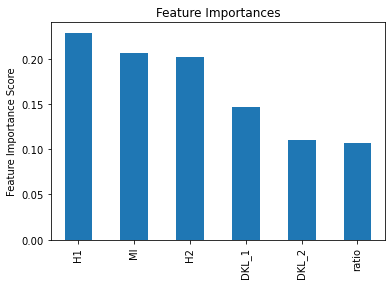

In [26]:
feat_imp = pd.Series(best_model.feature_importances_, X_train.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

##### Plot confusion matrix:

In [27]:
cm = confusion_matrix(y_test, y_pred)

In [28]:
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[1050  857]
 [ 583 1287]]


<AxesSubplot:>

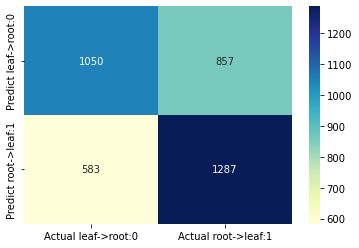

In [29]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual leaf->root:0', 'Actual root->leaf:1'], 
                                 index=['Predict leaf->root:0', 'Predict root->leaf:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.55      0.59      1907
           1       0.60      0.69      0.64      1870

    accuracy                           0.62      3777
   macro avg       0.62      0.62      0.62      3777
weighted avg       0.62      0.62      0.62      3777



##### Save Models

In [31]:
pickle.dump(best_model, open("Models/naive_gridsearch.pkl", "wb"))

In [23]:
best_model = pickle.load(open("Models/naive_gridsearch.pkl", "rb"))
best_model

GradientBoostingClassifier(max_depth=8, max_features='sqrt',
                           min_samples_leaf=20, min_samples_split=20,
                           n_estimators=700, random_state=10, subsample=0.8)